In [ ]:
pip install pyAstronomy

In [ ]:
pip install arviz

In [ ]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import io
from PyAstronomy import pyasl
import time
r = pyasl.BallesterosBV_T()
b = pyasl.Ramirez2005()

uploaded = files.upload()

data0 = data = np.array(pd.read_csv(io.BytesIO(uploaded['SItable1.csv'])))

Saving SItable1.csv to SItable1 (1).csv


In [ ]:
import tensorflow.math as tf_m
def mean_fn(x, y, a, b, c, d):
  return (np.exp(x))**(1/a) * b*(y - c)**(-d/a)/1000 #the m relation was through trial and error
#fn from Barnes 2007

In [ ]:
pd.read_csv(io.BytesIO(uploaded['SItable1.csv']))
#tolist makes array to list to remove 'dtype=float64' from the end of the array
te = data0[:,2].tolist()
tee= data0[:,3].tolist()
age = data0[:,4].tolist()
agle = data0[:,5].tolist()
ague = data0[:,6].tolist()
mass = data0[:,7].tolist()
massle = data0[:,8].tolist()
massue = data0[:,9].tolist()
p = data0[:,21].tolist()
pl = data0[:,22].tolist()
pu = data0[:,23].tolist()

In [ ]:
p_n = []
a_n = []
index = 0
for i in range(0, len(p)-index):
  if (p[i]<3 and age[i]>7) or age[i]>11:
    index = index+1
for i in range(0, len(p)-index):
  if (p[i]<3 and age[i]>7) or age[i]>11:
    te.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    tee.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    age.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    agle.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    ague.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    mass.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    massle.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    massue.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    p.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    pl.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    pu.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    

mass_error = (np.array(massle) + np.array(massue))/2
age_error = (np.array(agle)+np.array(ague))/2#np.log(age) - np.log(np.array(age) - np.array(agle))
p_error = ((np.array(pl)+np.array(pu))/2)#/np.array(p)#(np.log(p) - np.log(np.array(p)-np.array(pl)))

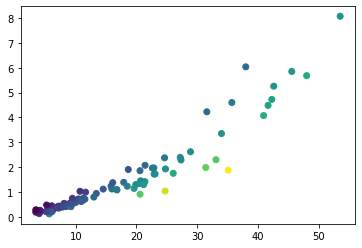

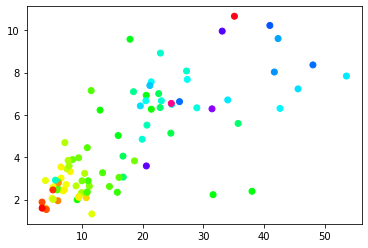

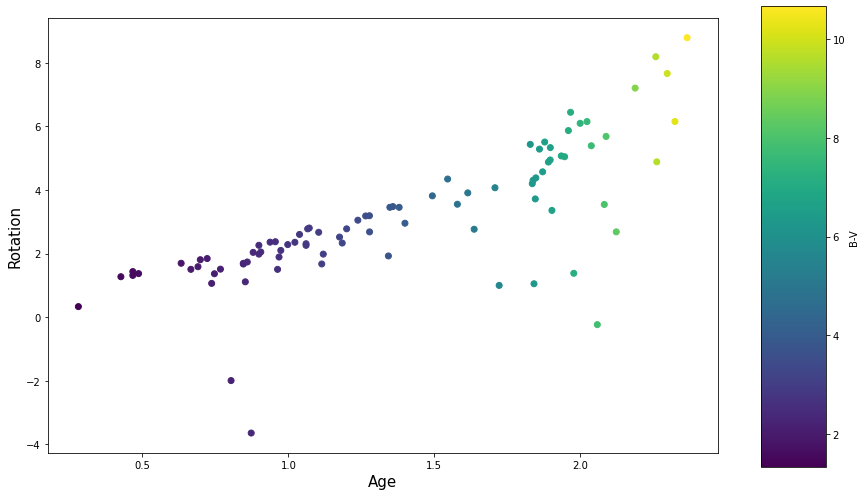

In [ ]:
data = np.array([te, p, age, mass]).T
a = 0.5189
b=0.75
c=0.4
d=0.601
X1 = np.log(data[:,2]) #age
X2 = r.t2bv(data[:,0])#data[::al,2] #B_V
X3 = data[:, 3] #mass
x = mean_fn(np.log(data[:,1]), X2, a, b, c, d)
plt.scatter(p, x, c=X2, cmap='viridis')
plt.show()
plt.scatter(p, age, c=X2, cmap='hsv')
subtract = data[:,2]-x
plt.show()
fig = plt.figure(figsize=(12, 8))
plt.scatter(X1, subtract, c=data[:,2], cmap='viridis')
plt.xlabel('Age', size=15)
plt.ylabel('Rotation', size=15)
#plt.subplots_adjust(bottom=np.min(X2), top=np.max(X2))
cax = plt.axes([0.95, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax, label='B-V')
plt.show()

In [ ]:
d0 = []
d1 = []
d2 = []
d3 = []

for i in range(len(data[:,3])):
  if data[i, 1]>0:
    d0.append(data[i, 0])
    d1.append(data[i, 1])
    d2.append(data[i, 2])
    d3.append(data[i, 3])

data1 = np.array([d0, d1, d2, d3]).T

In [ ]:
# uploaded = files.upload()

# data0 = data = np.array(pd.read_csv(io.BytesIO(uploaded['Data1.csv'])))
# p = data[:,1] #period
# p_error = 0.1*p
# te = data[:,0]#data[::al,2] #B_V
# tee = 0.1*te
# X3 = data[:, 3] #mass
# mass = X3
# age = data[:,2]
# age_error = 0.2*age

In [ ]:
# data_r = []
# for num in range(0, len(data0)):
#   if np.random.random_sample()< 0.08:
#     data_r.append(data0[num])
# data_r = np.array(data_r)
# print(len(data_r))
# data = data_r

In [ ]:
tf.enable_v2_behavior()
t1 = time.perf_counter()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# observations from a known function at some random points.
X1 = np.log(p) #age
X2 = np.log10(te)#data[::al,2] #B_V
#X2 = np.array(te, dtype=np.float64)
X3 = np.array(mass)
observation_index_points = np.dstack([X1, X2]).reshape(-1, 2)

resolution = len(X2)
X1_test = np.log(np.linspace( np.min(data[::,2]), np.max(data[::,2]), num=resolution ))
X2_test = np.linspace( np.min(X2), np.max(X2), num=resolution )
X3_test = np.linspace( np.min(X3), np.max(X3), num=resolution )
X_test = np.dstack([X1_test, X2_test]).reshape(resolution,2)# resolution, resolution, 3)

a = 0.5189
b=0.75
c=0.4
d=0.601

Y = observations = np.array(age) - mean_fn(X1, r.t2bv(np.array(te)), a, b, c, d)
noise_variance = np.array(age_error)#/np.array(age)

gaussian_process_model = tfd.JointDistributionSequential([
  #tfd.Normal(np.float64(3), np.float64(.0001)),
  #tfd.Normal(np.float64(3), np.float64(.0001)),
  #tfd.LogNormal(np.float64(2), np.float64(.0001)),
  #tfd.Normal(np.float64(1), np.float64(.0001)),
  #tfd.Normal(np.float64(1), np.float64(.0001)),
  #tfd.LogNormal(np.float64(3), np.float64(.0001)),
  tfd.Normal(X1.reshape(-1), (np.array(p_error)/np.array(p)).reshape(-1)),
  tfd.Normal(X2.reshape(-1), 0.43*np.array(tee)/np.array(te).reshape(-1)),
  #tfd.Normal(X3.reshape(-1), np.array(mass_error).reshape(-1)),
  lambda oservations1_, observations2_: tfd.GaussianProcess(
      #kernel=psd_kernels.ExponentiatedQuadratic(amplitude1, length_scale1)*psd_kernels.ExponentiatedQuadratic(amplitude2, length_scale2),
      kernel=psd_kernels.ExponentiatedQuadratic(np.mean(10), np.mean(1))*psd_kernels.ExponentiatedQuadratic(np.mean(10), np.mean(0.5)),
      index_points=observation_index_points, observation_noise_variance=noise_variance)])

initial_chain_states = [
    #3 * tf.ones([len(X1)], dtype=np.float64, name='init_amplitude'),
    #3 * tf.ones([len(X1)], dtype=np.float64, name='init_amplitude'),
    #2 * tf.ones([len(X1)], dtype=np.float64, name='init_amplitude'),
    #1 * tf.ones([len(X1)], dtype=np.float64, name='init_length_scale1'),
    #1 * tf.ones([len(X1)], dtype=np.float64, name='init_length_scale2'),
    #3 * tf.ones([len(X1)], dtype=np.float64, name='init_length_scale3'),
    tf.convert_to_tensor(X1.reshape(-1), dtype=np.float64, name='observations1_'),
    tf.convert_to_tensor(X2.reshape(-1), dtype=np.float64, name='observations2_')]
    #tf.convert_to_tensor(X3.reshape(-1), dtype=np.float64, name='observations3_')]

unconstraining_bijectors = [
    #tfp.bijectors.Softplus(),
    #tfp.bijectors.Softplus(),
    #tfp.bijectors.Softplus(),
    #tfp.bijectors.Softplus(),
    #tfp.bijectors.Softplus(),
    #tfp.bijectors.Softplus(),
    #tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus()]

def unnormalized_log_posterior(*args):
  return gaussian_process_model.log_prob(*args, x=observations)

num_results = 500
num_burnin_steps = 12000
@tf.function
def run_mcmc():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      num_steps_between_results=10,
      current_state=initial_chain_states,
      kernel=tfp.mcmc.SimpleStepSizeAdaptation(
          inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=unnormalized_log_posterior,
              step_size=[np.float64(1e-7)],
              num_leapfrog_steps=3), 
              num_adaptation_steps=int(num_burnin_steps)),
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
# [
#       amplitudes1,
#       amplitudes2,
#       length_scales1,
#       length_scales2,
[
      observations1_,
      observations2_
], is_accepted = run_mcmc()


print("Acceptance rate: {}".format(np.mean(is_accepted)))
observation_index_points = np.dstack([np.mean(observations1_, axis=0), np.mean(observations2_, axis=0)]).reshape(-1,2)
Y = observations = np.array(age) - mean_fn(np.mean(observations1_, axis=0), r.t2bv(10**np.mean(observations2_, axis=0)), a, b, c, d)
#kernel = psd_kernels.ExponentiatedQuadratic(np.mean(amplitudes1), np.mean(length_scales1))*psd_kernels.ExponentiatedQuadratic(np.mean(amplitudes2), np.mean(length_scales2))
kernel = psd_kernels.ExponentiatedQuadratic(np.mean(10), 3)*psd_kernels.ExponentiatedQuadratic(np.mean(10), 5)

gp = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=X_test,
    observation_index_points=observation_index_points,
    observations= observations,
    observation_noise_variance=noise_variance)

#print("Final NLL = {}".format(neg_log_likelihood_))

samples = gp.sample(10).numpy()
var = np.array(gp.variance())
# ==> 10 independently drawn, joint samples at `index_points`.
# ==> 10 independently drawn, noisy joint samples at `index_points`
t2 = time.perf_counter()
print()

Acceptance rate: 0.7714545454545455



In [ ]:
np.mean(observations1_, axis=0).shape

(88,)

In [ ]:
acf = tfp.stats.auto_correlation(
    observations1_, axis=-1, max_lags=None, center=True, normalize=True,
    name='auto_correlation'
)

/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:496: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (176) in plot_autocorr, generating only 40 plots
  UserWarning,


'\n, var_names=("amplitudes",\n      "length_scales",\n      "observation_noise_variances"))'

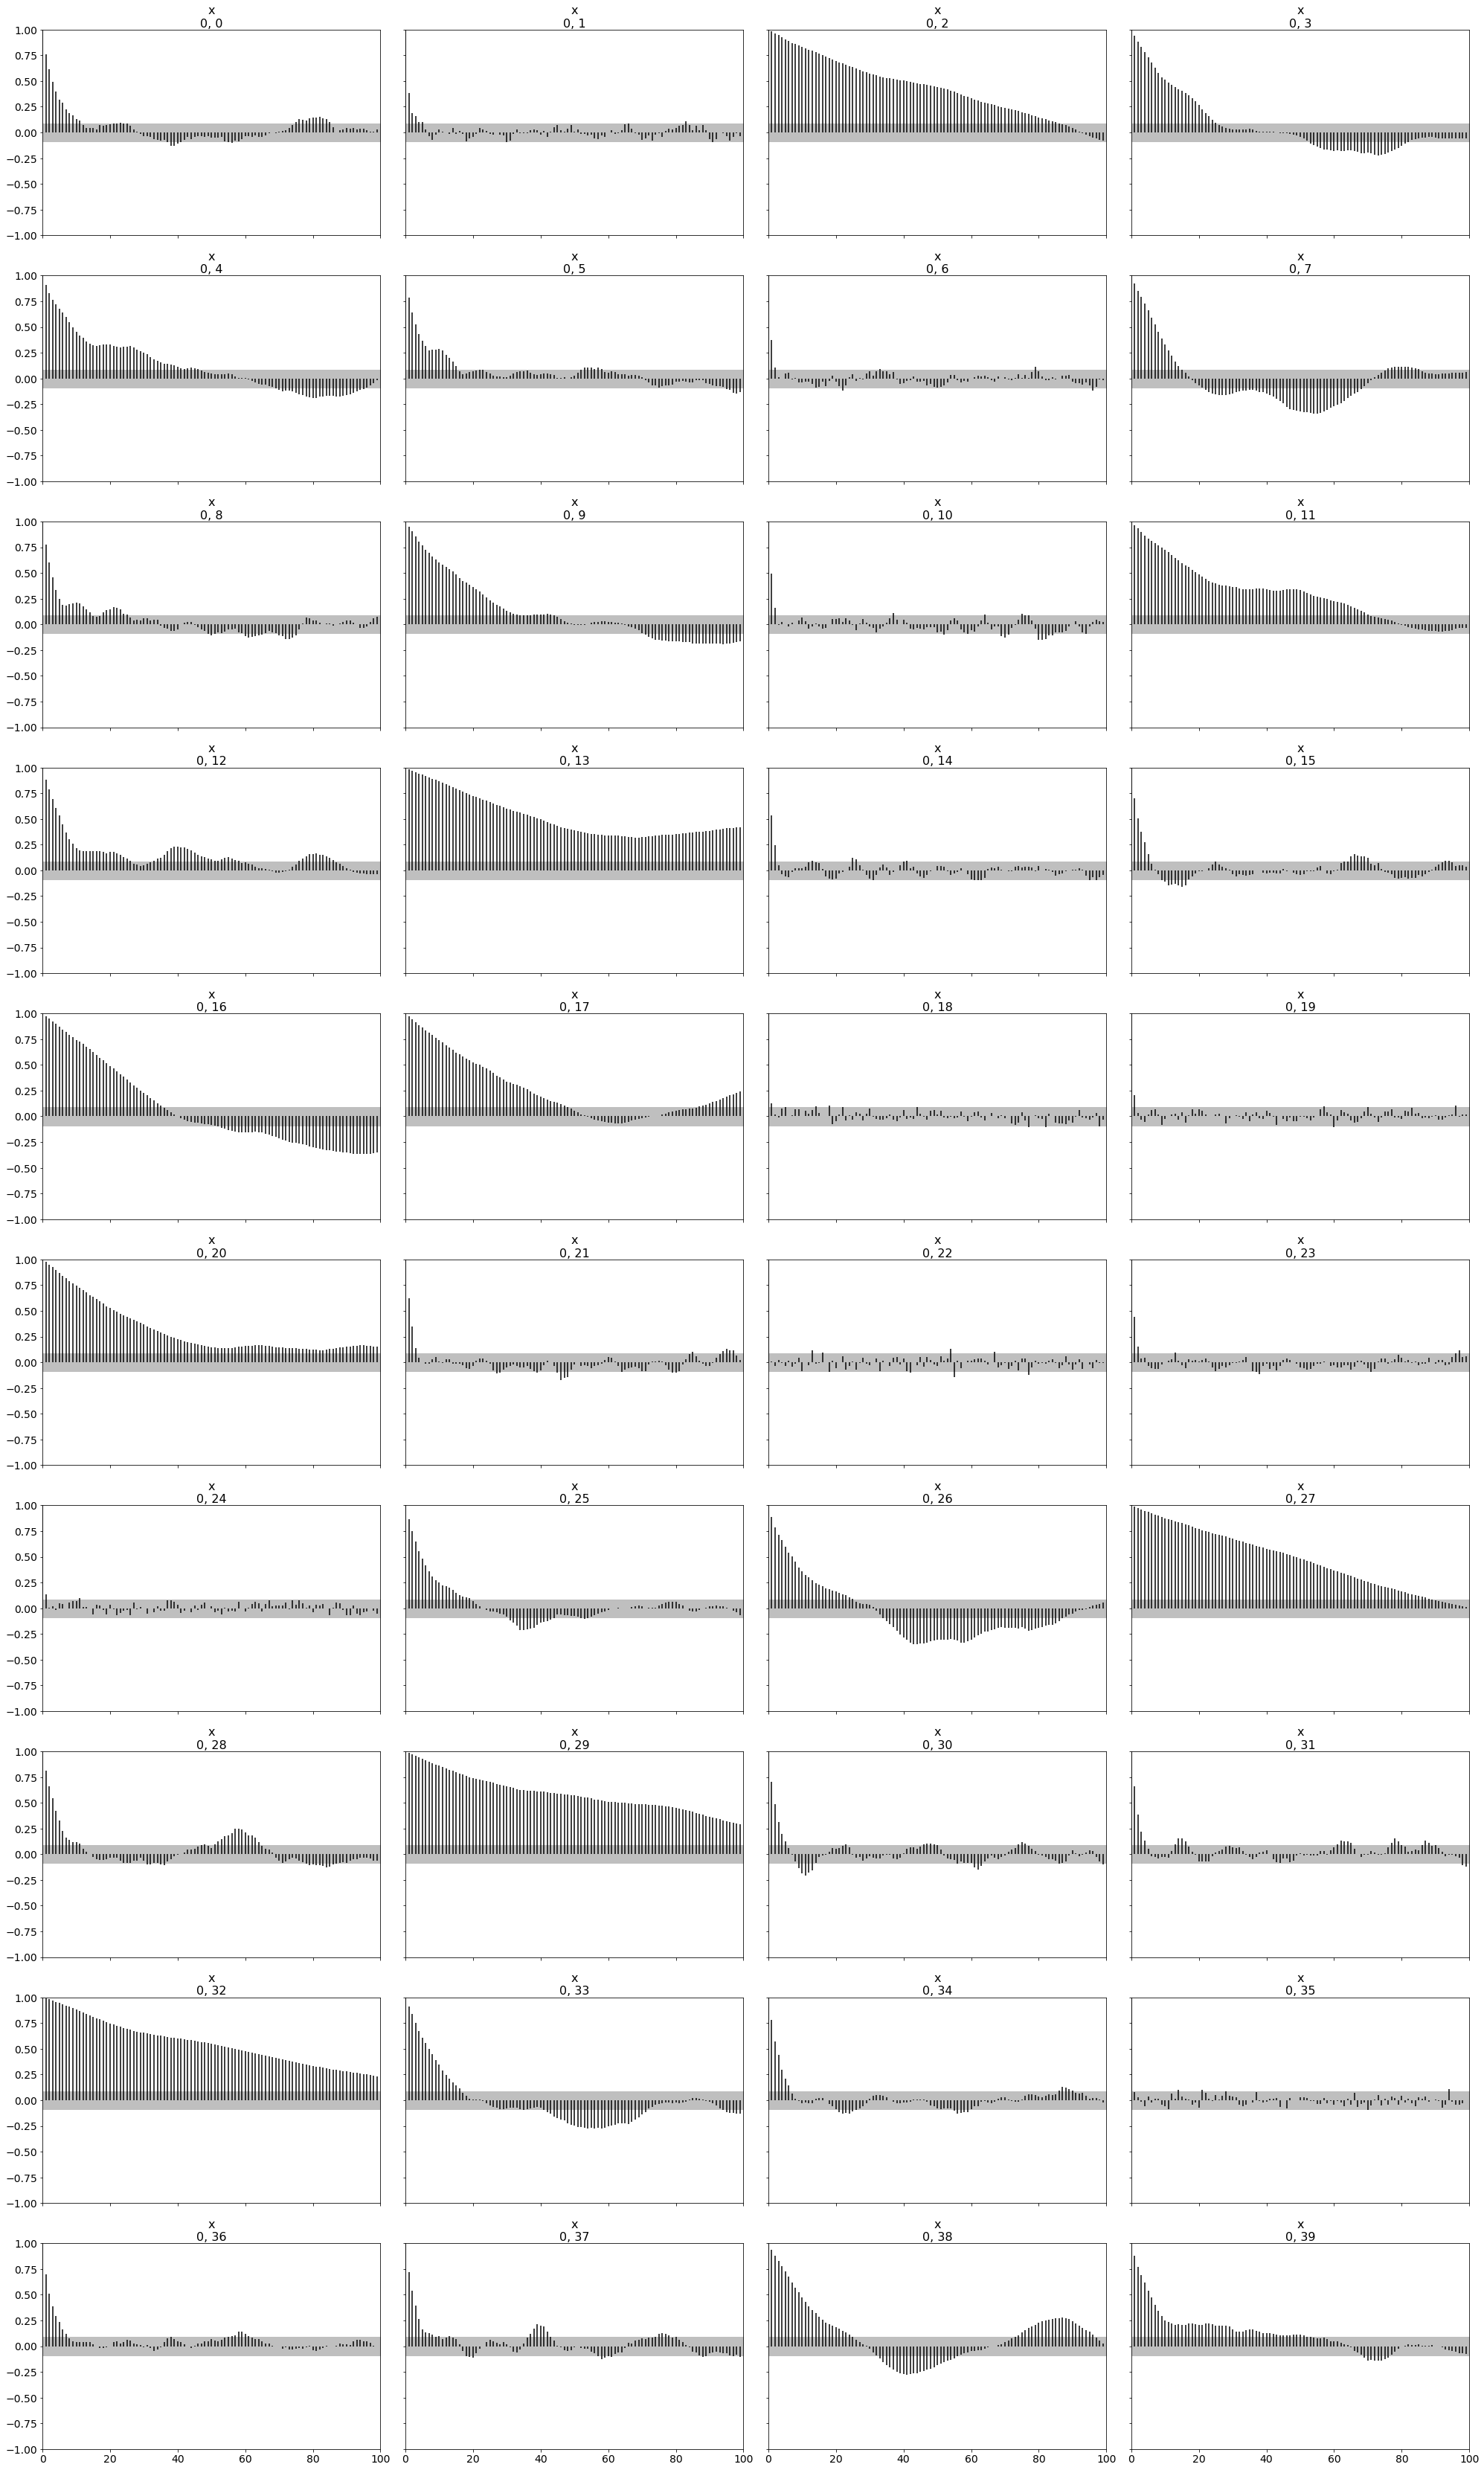

In [ ]:
var1 = np.array([observations1_,
      observations2_])
az.plot_autocorr(var1)
'''
, var_names=("amplitudes",
      "length_scales",
      "observation_noise_variances"))'''

In [ ]:
samples_mean = np.mean(samples, axis=0)

In [ ]:
numElems = len(Y)
sample = samples[9] + mean_fn(observation_index_points[:,0], r.t2bv(10**observation_index_points[:,1]), a ,b ,c ,d)
idx = np.round(np.linspace(0, len(np.array(sample).reshape(numElems**2)) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data

mu_test = (np.array(sample).reshape(numElems**2)[idx])
sd_test = (np.array(var).reshape(numElems**2)[idx]) 

vals = np.sort([mu_test, sd_test], axis=1)

print(np.mean(Y))


3.029598536474929


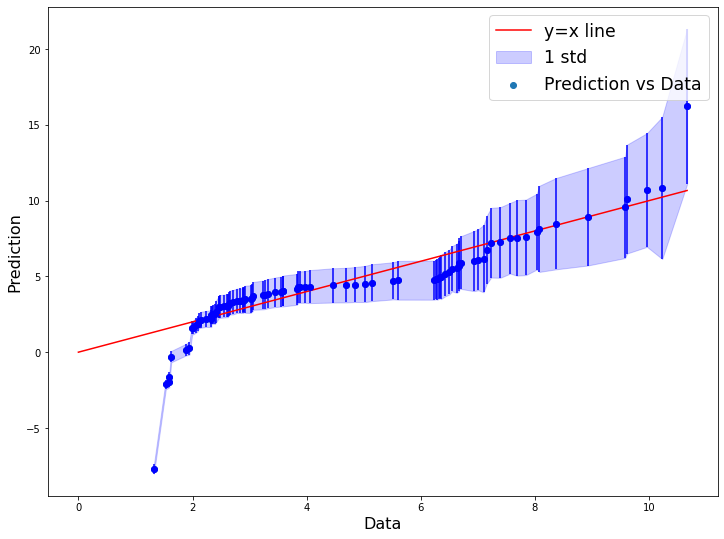

In [ ]:
font = {'size': 16,
        }
plt.figure(figsize=(12,9))
plt.errorbar(np.sort(age), vals[0,:], yerr=vals[1,:]**0.5, fmt='bo')
plt.fill_between(np.sort(age), vals[0,:] - vals[1,:]**0.5, vals[0,:] + vals[1,:]**0.5, color='blue', alpha=0.2, label='1 std')
plt.scatter(np.sort(age), np.sort(mu_test), label='Prediction vs Data')
x = np.linspace(0, max(age))
plt.plot(x, x , 'r', label='y=x line')
plt.xlabel('Data', fontdict=font)
plt.ylabel('Prediction', fontdict=font)
plt.legend(fontsize='xx-large')

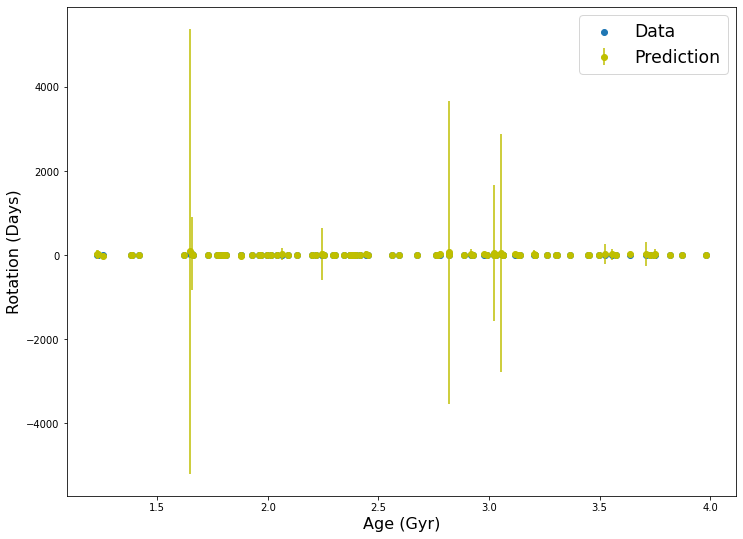

In [ ]:
plt.figure(figsize=(12,9))
plt.errorbar(X1, np.sort(vals[0]), yerr=vals[1], fmt='o', c='y', label='Prediction')
plt.scatter(X1, np.sort(age), label='Data')
plt.xlabel('Age (Gyr)', fontdict=font)
plt.ylabel('Rotation (Days)', fontdict=font)
plt.legend(fontsize='xx-large')

(88,)


Text(0, 0.5, 'Frequency')

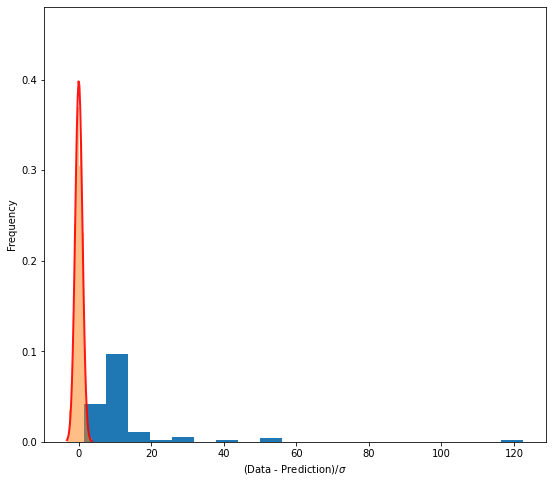

In [ ]:
Z = (np.sort(data[:,1])-vals[0,:])/vals[1,:]
print(Y.shape)
plt.figure(figsize=(9,8))
plt.hist(Z, density=True, bins=20)
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, alpha=0.5)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', alpha=0.9)
plt.xlabel('(Data - Prediction)/$\sigma$')
plt.ylabel('Frequency')

In [ ]:
import collections 
PooledModel = collections.namedtuple('PooledModel', ['Amplitude1','Amplitude2', 'Length_Scale1', 'Length_Scale2'])
samplesN = [
      amplitudes1,
      amplitudes2,
      length_scales1,
      length_scales2
]
pooled_samples = PooledModel._make(samplesN)

In [ ]:
for var2, var_samples in pooled_samples._asdict().items():
  print('R-hat for ', var2, ':\t',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

In [ ]:
import seaborn as sns
def plot_traces(var_name, samples, num_chains):
  if isinstance(samples, tf.Tensor):
    samples = samples.numpy() # convert to numpy array
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    axes[0].plot(samples[:, chain], alpha=0.7)
    axes[0].title.set_text("'{}' trace".format(var_name))
    sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel(var_name)
  plt.show()

In [ ]:
for var1, var_samples in pooled_samples._asdict().items():
  plot_traces(var2, samples=var_samples, num_chains=4)